In [1]:
import os
import sys
import time
from itertools import chain

import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numba import jit
import numpy as np
from tqdm import tqdm
import seaborn as sns
from scipy.optimize import curve_fit
#sns.set_style("whitegrid")

#from jupyterthemes import jtplot
import analysis_quicklook

#jtplot.style()
sns.set_style("whitegrid")

In [2]:
runID = 326711
pedID = 326709
modlist = [1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 103, 106, 107, 108, 111, 112, 114, 115, 119, 121, 123, 124, 125, 126]
datadir = "/data/wipac/CTA/target5and7data/runs_320000_through_329999"
savedir = f"{datadir}/run{runID}"

maker = analysis_quicklook.Quicklooker(pedID, runID, modlist, datadir, savedir)

Initializing quicklook!
Trying to create save directory at: /data/wipac/CTA/target5and7data/runs_320000_through_329999/run326711
Pedestal database found!
Calibrated data found!


In [3]:
datafile = f"/data/wipac/CTA/target5and7data/runs_320000_through_329999/run{runID}/event_stats_run{runID}.txt"
events, time_s, time_ns, charge_max, \
charge_mean, charge_std, p2p_max, \
p2p_mean, p2p_std, _, _, _, _, _ = np.loadtxt(datafile, delimiter=", ", skiprows=1, unpack=True)

events = events.astype("int")

time_s *= 10 ** 9
time_stamp = time_s + time_ns
time_stamp -= time_stamp[0]
time_stamp_delta_ts = [j - i for i, j in zip(time_stamp[:-1], time_stamp[1:])]
flasher_delta_ts = [i for i in time_stamp_delta_ts if i > 1.0001e8 and i < 1.003e8]
mean = np.mean(flasher_delta_ts)
std = np.std(flasher_delta_ts)

def find_nearest(array, value):
    return ((np.abs(np.asarray(array) - value)).argmin())
    
flasher_ev = find_nearest(time_stamp_delta_ts, mean)
time_pos = time_stamp[flasher_ev]
temp1 = list(np.asarray(time_stamp) - np.rint(time_pos) - mean / 2.0)
temp2 = [(int(np.rint(i)) % int(np.rint(mean))) - mean / 2.0 for i in temp1]
flashers = [i for i, res in enumerate(temp2) if np.abs(res) < 200 * std and charge_mean[i] > 700]
print(len(flashers))
print(len(time_stamp))
showers = [i for i in range(len(time_stamp)) if charge_mean[i] > 700 and i not in flashers]

6343
7116


In [4]:
charges = []

for event in tqdm(flashers):
    waveforms = np.zeros((maker.n_pixels, maker.n_samples), dtype=np.float32)
    maker.calreader.GetR1Event(event, waveforms)
    ev_analysis = analysis_quicklook.EventAnalyzer(waveforms, maker.n_samples, maker.n_pixels)
    charges.append(ev_analysis.charge)
    
charges_ev = np.asarray(charges)
print(charges_ev.shape)

100%|██████████| 6343/6343 [03:09<00:00, 33.56it/s]


(6343, 1536)


In [5]:
charges = charges_ev.T
print(charges.shape)
charges[:576, :] *= 2.0

(1536, 6343)


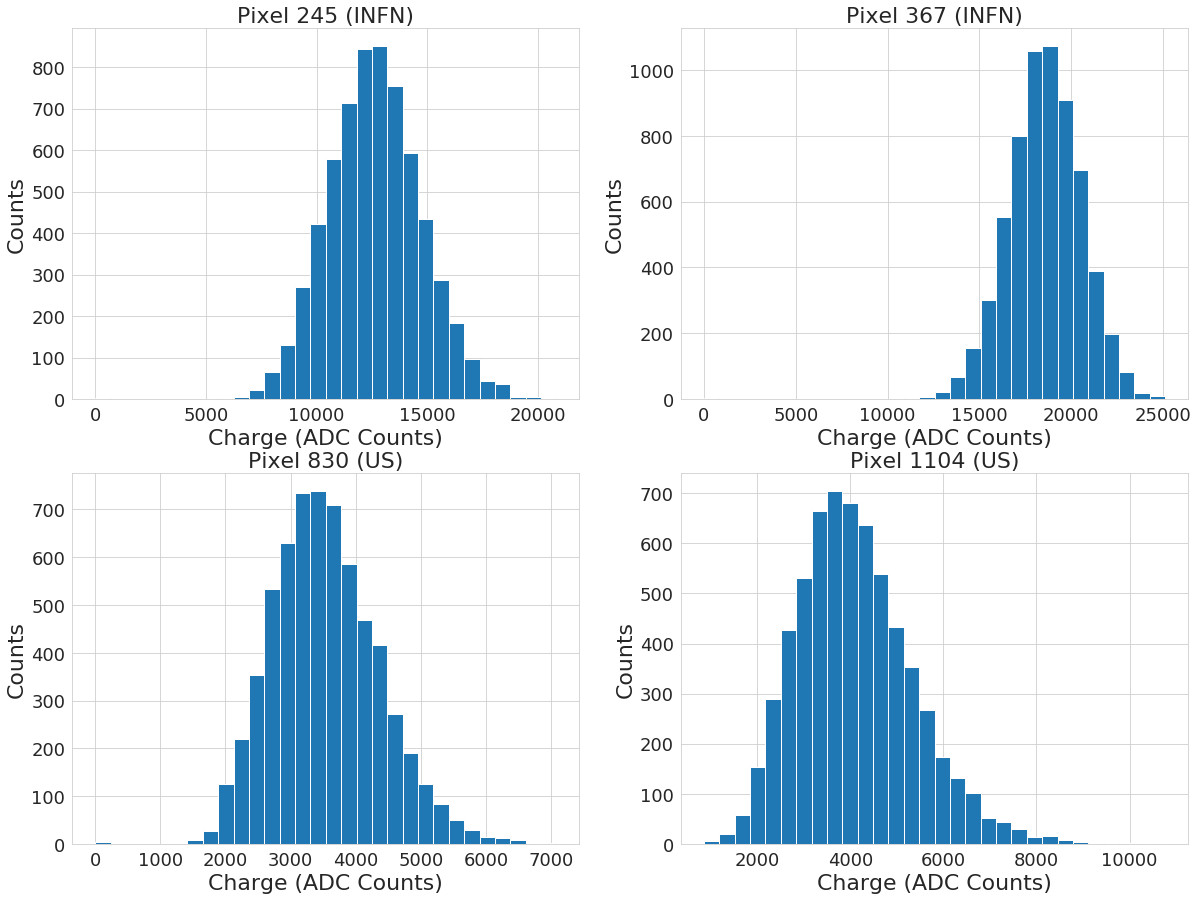

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

ax[0, 0].hist(charges[245], bins=30)
ax[0, 0].set_xlabel("Charge (ADC Counts)", fontsize=22)
ax[0, 0].set_ylabel("Counts", fontsize=22)
ax[0, 0].set_title("Pixel 245 (INFN)", fontsize=22)

ax[0, 1].hist(charges[367], bins=30)
ax[0, 1].set_xlabel("Charge (ADC Counts)", fontsize=22)
ax[0, 1].set_ylabel("Counts", fontsize=22)
ax[0, 1].set_title("Pixel 367 (INFN)", fontsize=22)

ax[1, 0].hist(charges[830], bins=30)
ax[1, 0].set_xlabel("Charge (ADC Counts)", fontsize=22)
ax[1, 0].set_ylabel("Counts", fontsize=22)
ax[1, 0].set_title("Pixel 830 (US)", fontsize=22)

ax[1, 1].hist(charges[1104], bins=30)
ax[1, 1].set_xlabel("Charge (ADC Counts)", fontsize=22)
ax[1, 1].set_ylabel("Counts", fontsize=22)
ax[1, 1].set_title("Pixel 1104 (US)", fontsize=22)

for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(labelsize=18)

In [7]:
mu = np.zeros(charges.shape[0])
var = np.zeros(charges.shape[0])

mu = np.mean(charges, axis=1)
sigma = np.std(charges, axis=1, ddof=1)
print(mu.shape)

(1536,)


In [8]:
gain = (sigma ** 2) / mu
num_pes = (mu ** 2) / (sigma ** 2)
print([i for i, boo in enumerate(np.isnan(num_pes)) if bool(boo) is True])

#@jit
def remove_nan(array):
    for i, boo in enumerate(np.isnan(array)):
        if bool(boo) is True:
            array[i] = 0

remove_nan(gain)
remove_nan(num_pes)
print([i for i, boo in enumerate(np.isnan(gain)) if bool(boo) is True])
print([i for i, boo in enumerate(np.isnan(num_pes)) if bool(boo) is True])
#print(list(gain))
#print(list(num_pes))

[352]
[]
[]


/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [9]:
for i, val in enumerate(gain):
    if val > 1.0e-4:
        gain[i] = val
    else:
        gain[i] = 1.0

gain_file = "/data/wipac/CTA/target5and7data/runs_320000_through_329999/gain_calibration.hdf5"
f = h5py.File(gain_file, 'w')

f.create_dataset("Gains", data=gain)
f.close()

In [10]:
print(len([val for val in gain if val < 1.0e-4]))

0


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
ax[0, 0].hist(mu[:576], bins=30, label="INFN", alpha=0.7)
ax[0, 0].hist(mu[576:], bins=30, label="US", alpha=0.7)
ax[0, 0].set_xlabel("Mean Charge (ADC ns)", fontsize=24)
ax[0, 0].legend(fontsize=20)

ax[0, 1].hist(sigma[:576], bins=30, label="INFN", alpha=0.7)
ax[0, 1].hist(sigma[576:], bins=30, label="US", alpha=0.7)
ax[0, 1]. set_xlabel("Charge Sigma (ADC ns)", fontsize=24)
ax[0, 1].legend(fontsize=20)

ax[1, 0].hist(gain[:576], bins=30, range=(0, 750), label="INFN", alpha=0.7)
ax[1, 0].hist(gain[576:], bins=30, range=(0, 750), label="US", alpha=0.7)
ax[1, 0].set_xlabel("Calculated Gain (ADC ns / pe)", fontsize=24)
ax[1, 0].legend(fontsize=20)

ax[1, 1].hist(num_pes[:576], bins=30, label="INFN", alpha=0.7)
ax[1, 1].hist(num_pes[576:], bins=30, label="US", alpha=0.7)
ax[1, 1].set_xlabel("Mean Number of Photoelectrons (pe)", fontsize=24)
ax[1, 1].legend(fontsize=20)
for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(labelsize=18)
        ax[i, j].set_ylabel("Counts", fontsize=24)

In [93]:
plt.clf()
print(showers)
for event in showers:
    waveforms = np.zeros((maker.n_pixels, maker.n_samples), dtype=np.float32)
    maker.calreader.GetR1Event(event, waveforms)
    maker.calreader.GetTimeStamp(event)
    ev_analysis = analysis_quicklook.EventAnalyzer(waveforms, maker.n_samples, maker.n_pixels)
    ev_analysis.charge[:576] *= 2.0
    print("Charge")
    print(ev_analysis.charge)
    print("Gain")
    print(gain)
    pe = ev_analysis.charge / gain
    print("PE")
    print(list(pe))

[3324, 6277]
Charge
[16973.309  16507.719  16285.072  ...  4937.941   3630.8083  3769.2642]
Gain
[316.86157 268.88287 348.41962 ... 214.9247  203.68488 212.41327]
PE
[53.56695, 61.393715, 46.739826, 59.610817, 31.42998, 67.62423, 61.55796, 45.40246, 21.438429, 55.40719, 59.92916, 51.673252, 71.03553, 36.79984, 57.27085, 50.499733, 40.021416, 35.602978, 35.896046, 49.005234, 53.781982, 38.253765, 52.669636, 56.719284, 43.28402, 47.646088, 42.465313, 53.523293, 40.695866, 46.784103, 60.570034, 46.185112, 48.70303, 43.080727, 58.907352, 70.48415, 39.592514, 37.9558, 35.71173, 57.191833, 53.37781, 34.15468, 60.003876, 51.30423, 35.9085, 54.489876, 41.43496, 61.49714, 59.156406, 71.249916, 53.741302, 58.97326, 49.86487, 57.371254, 44.74433, 61.148304, 58.11196, 27.189838, 56.87628, 44.33309, 51.166924, 39.745975, 48.59932, 63.201363, 47.731594, 77.03303, 46.82739, 60.445244, 46.12497, 56.847485, 56.707867, 43.868603, 46.64553, 62.597095, 48.99459, 61.550243, 52.41864, 46.288174, 50.7578, 51

/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


<Figure size 432x288 with 0 Axes>

In [105]:
runID = 328540
pedID = 328534
modlist = [1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 103, 106, 107, 108, 111, 112, 114, 115, 119, 121, 123, 124, 125, 126]
datadir = "/data/wipac/CTA/target5and7data/runs_320000_through_329999"
savedir = f"{datadir}/run{runID}"

maker = analysis_quicklook.Quicklooker(pedID, runID, modlist, datadir, savedir)
datafile = f"/data/wipac/CTA/target5and7data/runs_320000_through_329999/run{runID}/event_stats_run{runID}.txt"
events, time_s, time_ns, charge_max, \
charge_mean, charge_std, p2p_max, \
p2p_mean, p2p_std = np.loadtxt(datafile, delimiter=", ", skiprows=1, unpack=True)

events = events.astype("int")

time_s *= 10 ** 9
time_stamp = time_s + time_ns
time_stamp -= time_stamp[0]
time_stamp_delta_ts = [j - i for i, j in zip(time_stamp[:-1], time_stamp[1:])]
flasher_delta_ts = [i for i in time_stamp_delta_ts if i > 1.0001e8 and i < 1.003e8]
mean = np.mean(flasher_delta_ts)
std = np.std(flasher_delta_ts)

def find_nearest(array, value):
    return ((np.abs(np.asarray(array) - value)).argmin())
    
flasher_ev = find_nearest(time_stamp_delta_ts, mean)
time_pos = time_stamp[flasher_ev]
temp1 = list(np.asarray(time_stamp) - np.rint(time_pos) - mean / 2.0)
temp2 = [(int(np.rint(i)) % int(np.rint(mean))) - mean / 2.0 for i in temp1]
flashers = [i for i, res in enumerate(temp2) if np.abs(res) < 200 * std and charge_mean[i] > 700]
print(len(flashers))
print(len(time_stamp))
showers = [i for i in range(len(time_stamp)) if charge_mean[i] > 700 and i not in flashers]
pedir = "/home/bmode/public_html/cta/"
try:
    os.mkdir(pedir)
except:
    pass

for event in tqdm(range(6279, 6280)):
    #print(f"Processing event: {event}")
    waveforms = np.zeros((maker.n_pixels, maker.n_samples), dtype=np.float32)
    physHeatArr = np.zeros((maker.n_modules, 8, 8))

    maker.calreader.GetR1Event(event, waveforms)
    maker.calreader.GetTimeStamp(event)
    ev_analysis = analysis_quicklook.EventAnalyzer(waveforms, maker.n_samples, maker.n_pixels)
    ev_analysis.charge[:576] *= 2.0
    pe = ev_analysis.charge / gain
    #print(list(pe))
    maxZ = np.nanmax(pe)
    new_pe = np.reshape(pe, (maker.n_modules, -1))
    physHeatArr[:, maker.row, maker.col] = new_pe
    #print(list(physHeatArr))
    
    heatReflectFig = plt.figure('Heat Map Skyview', (18, 15))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.04, hspace=0.04)

    for mod_index in range(maker.n_modules):
        loc, locReflect = maker.calc_loc(mod_index)
        if loc[1] % 2 == 0:
            physHeatArr[mod_index, :, :] = np.rot90(physHeatArr[mod_index, :, :], k=2)

        plt.figure('Heat Map Skyview')
        ax = plt.subplot(gs[locReflect])
        c = ax.pcolor(physHeatArr[mod_index, :, ::-1], vmin=0, vmax=maxZ, cmap='viridis')
        ax.axis('off')
        ax.set_aspect('equal')
    #print(list(physHeatArr[mod_index, :, ::-1]))
    heatReflectFig.subplots_adjust(right=0.8, top=0.9, bottom=0.1)
    cbar_ax = heatReflectFig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = heatReflectFig.colorbar(c, cax=cbar_ax)
    cbar.set_label('Charge (pe)', rotation=270, size=20, labelpad=24)
    cbar_ax.tick_params(labelsize=16)
    heatReflectFig.suptitle(f"Run {maker.runID} - Event {event}", fontsize=24)
    heatReflectFig.savefig(f"{pedir}/run{maker.runID}_ev{event}_pe_calibrated_skyheatmap_flasher.png")
    plt.clf()
print(f"Event images saved to: {pedir}")

Initializing quicklook!
Trying to create save directory at: /data/wipac/CTA/target5and7data/runs_320000_through_329999/run328540
Pedestal database found!
Calibrated data found!
4552
35824


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

Event images saved to: /home/bmode/public_html/cta/


<Figure size 1296x1080 with 0 Axes>

[352]
